<IPython.core.display.Javascript object>


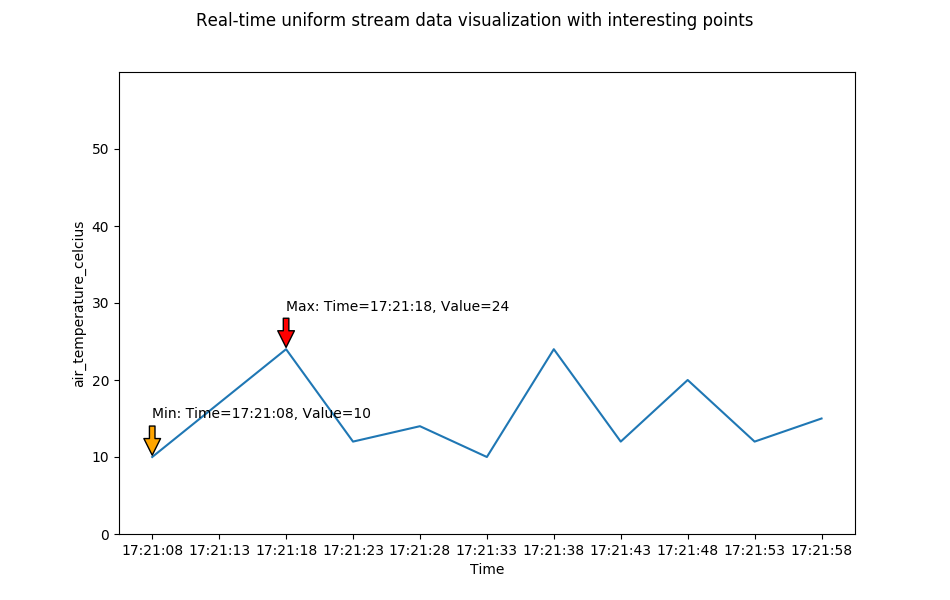

KeyboardInterrupt: 

In [1]:

from kafka import KafkaConsumer
import datetime as dt
from json import loads
import statistics
import matplotlib.pyplot as plt
import statistics

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'AssignmentB'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   # consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel("air_temperature_celcius")
        ax.set_ylim(0,60) 
        ax.set_yticks([0,10,20,30,40,50])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            message = message.value
            time = str(dt.datetime.now().strftime("%X"))
            x.append(time) 
            y.append(message["air_temperature_celcius"])
            # print(y)
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('air_temperature_celcius')
                ax.set_ylim(0,60) 
                ax.set_yticks([0,10,20,30,40,50])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

{'Fire_No': 11, 'time': '1:30'}
{'Fire_No': 8, 'time': '1:55'}
{'Fire_No': 8, 'time': '1:45'}
{'Fire_No': 7, 'time': '1:20'}
{'Fire_No': 7, 'time': '0:30'}
{'Fire_No': 7, 'time': '0:45'}
{'Fire_No': 6, 'time': '2:5'}
{'Fire_No': 6, 'time': '1:35'}
{'Fire_No': 6, 'time': '0:25'}
{'Fire_No': 5, 'time': '1:40'}


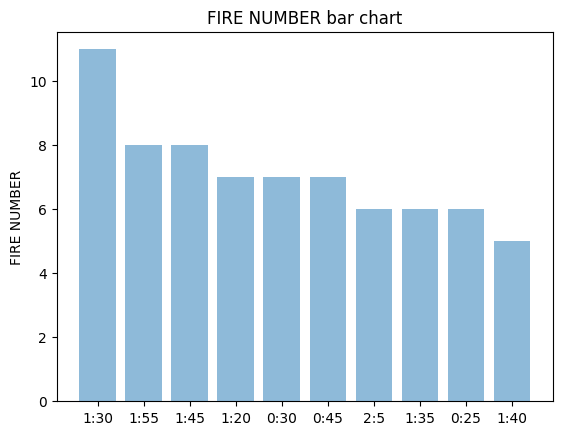

In [2]:
import geohash
import sys
import time
import json
from pymongo import MongoClient
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
client = MongoClient()
db=client.fit5148_assignment_db
climate_stream = db.climate_stream
hotspot_stream = db.hotspot_stream
import matplotlib.pyplot as plt;plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
time=[]
value=[] 
result=climate_stream.aggregate([{
                                    "$lookup":
                                           {    "from":"hotspot_stream",
                                                "localField":"create_time",
                                                "foreignField" :"match_date",
                                                "as":"fire"}
    
                                                                    },
                                
                                {
                                    "$group":{
                                        "_id":
                                      {  
                                          "year":{"$year":"$create_time"},
                                          "month":{"$month":"$create_time"},
                                          "dayOfYear":{"$dayOfYear":"$create_time"},
                                          "dayOfMonth":{"$dayOfMonth":"$create_time"},
                                         "hour":{"$hour":"$create_time"},
                                         "minute":{
                                            "$subtract":
                                            [
                                                {"$minute":"$create_time"},
                                                {"$mod":[{"$minute":"$create_time"},5]}
                                            ]
                                                 },
                                     },
                                        "Fire_No":{"$sum":{"$size":"$fire"}}
                                             }
                                },
                                {
                                    "$project":{
                                        "time":{
                                            "$concat":[
                                                #{"$substr":["$_id.year",0,-1]},"-",
                                                #{"$substr":["$_id.month",0,-1]},"-",
                                                #{"$substr":["$_id.dayOfMonth",0,-1]}," ",
                                                {"$substr":["$_id.hour",0,-1]},":",
                                                {"$substr":["$_id.minute",0,-1]}
                                            ]
                                        },
                                        "Fire_No":1,
                                        "_id":0
                                    }
                                },
                                {
                                    "$sort":{"Fire_No":-1}
                                },
                                {
                                    "$limit":10
                                }
      
                                                          ])
for i in result:
    pprint(i)
    time.append(i["time"])
    value.append(i["Fire_No"])

y_pos=np.arange(len(time))
plt.bar(y_pos,value,align='center',alpha=0.5)
plt.xticks(y_pos,time)
plt.ylabel("FIRE NUMBER")
plt.title("FIRE NUMBER bar chart")

plt.show()


In [14]:
import gmplot
# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 10) # latitude and longitude of melbourne city


In [15]:
result=climate_stream.aggregate([{
                                    "$lookup":
                                           {    "from":"hotspot_stream",
                                                "localField":"create_time",
                                                "foreignField" :"match_date",
                                                "as":"fire"}
    
                                                                    },
                                {"$unwind":"$fire"},
                                {"$project":{'latitude':1,'longitude':1,'air_temperature_celcius':1,'relative_humidity':1,'fire.confidence':1,
                                 'fire.surface_temperature_celcius':1,"_id":0}}])
for i in result:
    a="airtem:"+str(i['air_temperature_celcius'])+","+"surfacetem:"+str(i['fire']['surface_temperature_celcius'])+","+"relat_humdity:"+i['relative_humidity']+","+"confidence:"+str(i['fire']['confidence'])
    gmap.marker(i['latitude'], i['longitude'],title=a,color="red")

In [16]:
import webbrowser
# Drawing the map
gmap.draw("availableParkings.html")
webbrowser.open_new("availableParkings.html")

True